## Initialisation time series

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


In [14]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([])
	inp = keras.layers.Input(batch_shape= (batch_size, X.shape[1], X.shape[2]),name="input")
	rnn = keras.layers.LSTM(neurons, return_sequences=True, stateful=False,name="RNN")(inp)
	dens = keras.layers.Dense(1,name="dense")(rnn)#keras.layers.TimeDistributed(keras.layers.Dense(1,name="dense"))(rnn)
	model = keras.models.Model(inputs=[inp],outputs=[dens])
	model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
	model.summary()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


## Evaluation

Fonction de détermination de l'erreur absolue en pourcentage

Combien de \% d'écart en moyenne entre la donnée prédite et la donnée mesurée

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

## Importation des données

Colonnes importées : 2e, 3e et 8e colonnes

2e colonne : Temps
3e colonne : identifiant Antenne
7e colonne : Quantité de données

In [16]:
dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [17]:
dataset = dataframe.values

In [18]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

## Sélection des données

Isolation d'une antenne (ID : 39)

Convertion du temps en heures

In [19]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

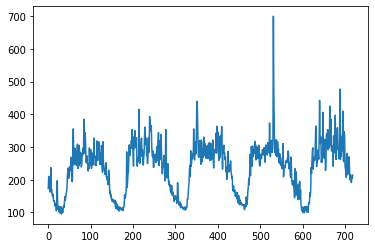

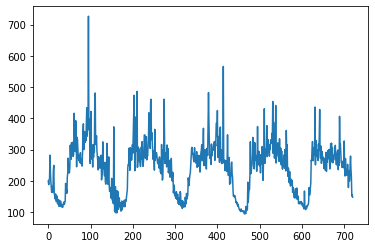

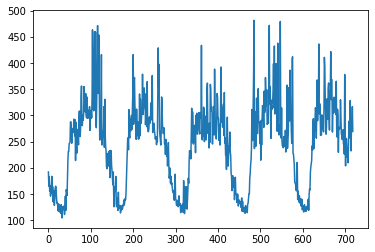

In [20]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

## Découpage du jeu de données

Définition d'un jeu d'entrainement et d'un jeu de test

Mise à l'échelle des données sur l'intervalle \[0,1\]

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


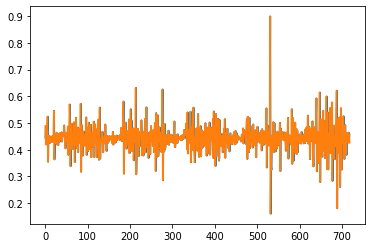

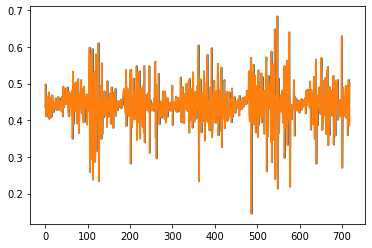

In [21]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [22]:
test_scaled[0]

raw_values[-int(l/3)-0]

191.95605

## Entrainement

In [23]:
hunits = 1

lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

(1439, 1, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(1, 1, 1)]               0         
_________________________________________________________________
RNN (LSTM)                   (1, 1, 1)                 12        
_________________________________________________________________
dense (Dense)                (1, 1, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


array([[[0.4420827 ]],

       [[0.45203984]],

       [[0.43661827]],

       ...,

       [[0.43576947]],

       [[0.4250751 ]],

       [[0.44293618]]], dtype=float32)

## Prédiction

Prédiction de la donnée et établissement d'un jeu de données prédite.

In [12]:
# walk-forward validation on the test data
predictions = list()
X = test_scaled[0, 0:-1]
X_diff_scaled = X
count=0
for i in range(1, len(test_scaled)):
	# make one-step forecast
	y_diff_scaled = forecast_lstm(lstm_model, 1, X_diff_scaled)
	# invert scaling
	y_diff = invert_scale(scaler, X_diff_scaled, y_diff_scaled)
	# invert differencing
	yhat = inverse_difference(raw_values, y_diff, len(test_scaled)+1-i)
	# store forecast
	expected = raw_values[len(train) + i + 1]
	if (np.abs(yhat - expected)/expected) > 0.3 :
		print('hour=%d, Transmitted=%f, Expected=%f' % ((i+1)/6, yhat, expected))
		X_diff_scaled = test_scaled[i, 0:-1]
		count+=1
	else :
		print('hour=%d, Not transmitted=%f, Expected=%f' % ((i+1)/6, yhat, expected))
		X_diff_scaled = y_diff_scaled
print(count/len(test_scaled))

hour=0, Not transmitted=189.884615, Expected=164.897003
hour=0, Not transmitted=163.600883, Expected=182.858307
hour=0, Not transmitted=181.690203, Expected=155.276047
hour=0, Not transmitted=154.129088, Expected=165.862061
hour=1, Not transmitted=164.718565, Expected=145.821472
hour=1, Not transmitted=144.678513, Expected=163.629761
hour=1, Not transmitted=162.486948, Expected=157.103607
hour=1, Not transmitted=155.960795, Expected=183.635971
hour=1, Not transmitted=182.493159, Expected=150.563354
hour=1, Not transmitted=149.420542, Expected=164.106354
hour=2, Not transmitted=162.963541, Expected=134.988403
hour=2, Not transmitted=133.845591, Expected=141.608185
hour=2, Not transmitted=140.465372, Expected=156.797821
hour=2, Not transmitted=155.655009, Expected=128.033493
hour=2, Not transmitted=126.890681, Expected=139.992706
hour=2, Not transmitted=138.849894, Expected=159.881165
hour=3, Not transmitted=158.738352, Expected=164.712021
hour=3, Not transmitted=163.569208, Expected=162

hour=25, Not transmitted=203.067731, Expected=194.252701
hour=25, Not transmitted=193.109937, Expected=179.312546
hour=25, Not transmitted=178.169782, Expected=167.345688
hour=25, Not transmitted=166.202924, Expected=192.026093
hour=25, Not transmitted=190.883329, Expected=147.733444
hour=26, Not transmitted=146.590681, Expected=125.498482
hour=26, Not transmitted=124.355718, Expected=163.487762
hour=26, Not transmitted=162.344999, Expected=161.096390
hour=26, Not transmitted=159.953626, Expected=156.546982
hour=26, Not transmitted=155.404218, Expected=183.446945
hour=26, Transmitted=182.304182, Expected=130.113937
hour=27, Not transmitted=133.526096, Expected=125.494881
hour=27, Not transmitted=125.101731, Expected=141.923218
hour=27, Not transmitted=140.904057, Expected=132.926910
hour=27, Not transmitted=131.804511, Expected=118.498741
hour=27, Not transmitted=117.359294, Expected=153.355042
hour=27, Not transmitted=152.212790, Expected=127.039879
hour=28, Not transmitted=125.897164

hour=49, Not transmitted=136.776884, Expected=146.001526
hour=50, Not transmitted=144.858762, Expected=187.715744
hour=50, Transmitted=186.572980, Expected=140.972809
hour=50, Not transmitted=146.732998, Expected=139.547180
hour=50, Not transmitted=139.538983, Expected=129.108994
hour=50, Not transmitted=128.153292, Expected=128.122192
hour=50, Not transmitted=127.010281, Expected=132.897980
hour=51, Not transmitted=131.760289, Expected=137.866653
hour=51, Not transmitted=136.724670, Expected=125.573875
hour=51, Not transmitted=124.431209, Expected=128.855545
hour=51, Not transmitted=127.712781, Expected=146.388565
hour=51, Not transmitted=145.245801, Expected=129.433960
hour=51, Not transmitted=128.291196, Expected=128.872574
hour=52, Not transmitted=127.729810, Expected=131.668411
hour=52, Not transmitted=130.525648, Expected=114.341827
hour=52, Not transmitted=113.199064, Expected=128.836563
hour=52, Not transmitted=127.693799, Expected=125.681923
hour=52, Not transmitted=124.539159

hour=74, Not transmitted=147.053770, Expected=133.513840
hour=74, Not transmitted=132.371076, Expected=150.028870
hour=74, Not transmitted=148.886106, Expected=147.046844
hour=74, Not transmitted=145.904081, Expected=126.847046
hour=75, Not transmitted=125.704282, Expected=133.513779
hour=75, Not transmitted=132.371015, Expected=138.442749
hour=75, Not transmitted=137.299985, Expected=131.955765
hour=75, Not transmitted=130.813001, Expected=134.734436
hour=75, Not transmitted=133.591672, Expected=134.035278
hour=75, Not transmitted=132.892515, Expected=124.649376
hour=76, Not transmitted=123.506612, Expected=136.012024
hour=76, Not transmitted=134.869260, Expected=142.389969
hour=76, Not transmitted=141.247205, Expected=116.817680
hour=76, Not transmitted=115.674917, Expected=135.760788
hour=76, Not transmitted=134.618024, Expected=123.157852
hour=76, Not transmitted=122.015089, Expected=122.672173
hour=77, Not transmitted=121.529409, Expected=115.891197
hour=77, Not transmitted=114.74

hour=99, Not transmitted=145.570164, Expected=132.514542
hour=99, Not transmitted=131.371778, Expected=137.102554
hour=99, Not transmitted=135.959791, Expected=141.428085
hour=99, Not transmitted=140.285322, Expected=126.807983
hour=99, Not transmitted=125.665220, Expected=131.631287
hour=99, Not transmitted=130.488523, Expected=139.483826
hour=100, Not transmitted=138.341062, Expected=120.017540
hour=100, Not transmitted=118.874776, Expected=127.596695
hour=100, Not transmitted=126.453931, Expected=125.245529
hour=100, Not transmitted=124.102766, Expected=115.659546
hour=100, Not transmitted=114.516782, Expected=117.857323
hour=100, Not transmitted=116.714559, Expected=129.406525
hour=101, Not transmitted=128.263761, Expected=116.901215
hour=101, Not transmitted=115.758451, Expected=124.424240
hour=101, Not transmitted=123.281476, Expected=118.005714
hour=101, Not transmitted=116.862951, Expected=116.772049
hour=101, Not transmitted=115.629285, Expected=125.926559
hour=101, Not transm

Generate proper data with 1 data shift

In [ ]:
# walk-forward validation on the training data
X_train = list()
y_train = list()

X_train.append(train_scaled[len(train_scaled)-1, 0:-1][0])
y_train.append(train_scaled[0, 0:-1][0])

for i in range(1,len(train_scaled)):
	# make one-step forecast
    X_train.append(train_scaled[i-1, 0:-1][0])
    y_train.append(train_scaled[i, 0:-1][0])
    
for i in range(len(train_scaled)):
	print('X_train=%f, y_train=%f' % (X_train[i], y_train[i]))

In [ ]:
# walk-forward validation on the testing data
X_test = list()
y_test = list()

X_test.append(test_scaled[len(test_scaled)-1, 0:-1][0])
y_test.append(test_scaled[0, 0:-1][0])

for i in range(1,len(test_scaled)):
	# make one-step forecast
    X_test.append(test_scaled[i-1, 0:-1][0])
    y_test.append(test_scaled[i, 0:-1][0])
    
for i in range(len(test_scaled)):
	print('X_test=%f, y_test=%f' % (X_test[i], y_test[i]))

## LSTM model

Our goal is to create a LSTM model to predict y_train using the time series X_train

In [ ]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
model1 = lstm_model
model1.summary()

In [ ]:
w = np.zeros(y_train_array.shape[:2])
D=1
w[D:] = 1 
w_train = w

from keras.callbacks import ModelCheckpoint
start = time.time()
hist1 = model1.fit(X_train_array, y_train_array, 
                   batch_size=1,
                   epochs=50, 
                   verbose=False,
                   validation_split=0.5,
                   shuffle=False)
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

labels = ["loss","val_loss"]
for lab in labels:
    plt.plot(hist1.history[lab],label=lab + " model1")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
for layer in model1.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
print(warr)
print("\n")
print(uarr)
print("\n")
print(barr)

print(model1.layers[2].get_weights())
warr.shape,uarr.shape,barr.shape

In [ ]:
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

In [ ]:
c_tm1 = np.array([0]*hunits).reshape(1,hunits)
h_tm1 = np.array([0]*hunits).reshape(1,hunits)

In [ ]:
xs  = X_train_array
for i in range(len(xs)):
    x_t = xs[i].reshape(1,1)
    h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
print("h3={}".format(h_tm1))
print("c3={}".format(c_tm1))

In [ ]:
xs

In [ ]:
batch_size = 1
len_ts = len(xs)
nfeature = 1

inp = keras.layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  
rnn,s,c = keras.layers.LSTM(hunits, 
                         return_sequences=True,
                         stateful=False,
                         return_state=True,
                         name="RNN")(inp)
states = keras.models.Model(inputs=[inp],outputs=[s,c, rnn])

for layer in states.layers:
    for layer1 in model1.layers:
        if layer.name == layer1.name:
            layer.set_weights(layer1.get_weights())
            
h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,1))
print("h3={}".format(h_t_keras))
print("c3={}".format(c_t_keras))

In [ ]:
model1.layers[2].get_weights()

In [ ]:
states.layers[1]

In [ ]:
lstm_model.layers[0]

In [ ]:
file_object =  open('parameters.h', 'w')

In [ ]:
file_object.write("//\n// Generated by spiderweak using Python.\n//\n\n#ifndef CPP_PARAMETERS_H\n#define CPP_PARAMETERS_H\n\n")

In [ ]:
file_object.write("#define HUNIT " + str(hunits) + "\n\n")

In [ ]:
file_object.write("#endif //CPP_PARAMETERS_H\n\nconst int hunit = HUNIT;\n\nconst float lstm_cell_input_weights[4 * HUNIT] = {")

In [ ]:
model1.layers[1].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float lstm_cell_hidden_weights[4 * HUNIT * HUNIT] = {")

In [ ]:
model1.layers[1].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float lstm_cell_bias[4 * HUNIT] = {")

In [ ]:
model1.layers[1].get_weights()[2].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nstatic float lstm_cell_hidden_layer[HUNIT] = {")

In [ ]:
h_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\nstatic float lstm_cell_cell_states[HUNIT] = {")

In [ ]:
c_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float dense_weights[HUNIT] = {")

In [ ]:
model1.layers[2].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\nconst float dense_bias = ")

In [ ]:
model1.layers[2].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write(";\n")

In [ ]:
file_object.close()

In [ ]:


fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h_tm1.flatten(),h_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")

ax = fig.add_subplot(1,2,2)
ax.plot(c_tm1.flatten(),c_t_keras.flatten(),"p")
ax.set_xlabel("c by hand")
ax.set_ylabel("c by Keras")
plt.show()